In [1]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from basis_expansions.basis_expansions import NaturalCubicSpline
from regression_tools.dftransformers import (
    ColumnSelector, Identity,
    FeatureUnion, MapFeature,
    StandardScaler)

from regression_tools.plotting_tools import (
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.random.seed(154)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


# Regularized Regression: Ridge and Lasso

Regularized regression is a powerful technique used to control the complexity of predictive models.

## Case Study: The Balance Data Set

To explore how regularized regression works, we will revisit the `balance` dataset from our linear regression case study.  We will use regularization to control the complexity of our predictive model.

In [2]:
balance = pd.read_csv("balance_non_zero.csv", index_col=0)

In [3]:
balance.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,2067.055954
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,1005.591989
2,104.593,7075,514,4,71,11,Male,No,No,Asian,706.138202
3,148.924,9504,681,3,36,11,Female,No,No,Asian,1104.804369
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,862.114034


We are going to be dealing with both continuous and categorical features in this model.  Our treatments will be familiar at this point:

  - We will use cubic splines to capture potential non-linear relationships between continuous variables and the response.
  - We will use indicator encodings to include categorical variables in the model.
  
To keep the code organized, we've written a couple of functions to make creating spline and indicator pipelines easier.

In [4]:
def simple_spline_specification(name, knots):
    select_name = "{}_select".format(name)
    spline_name = "{}_spline".format(name)
    return Pipeline([
        (select_name, ColumnSelector(name=name)),
        (spline_name, NaturalCubicSpline(knots=knots))
    ])

def simple_indicator_specification(var_name, levels):
    select_name = "{}_select".format(var_name)
    map_features = []
    if not isinstance(levels, list):
        levels = [levels]
    for level in levels:
        indicator_name = "{}_{}_indicator".format(var_name, level)
        map_features.append(
            (indicator_name, MapFeature(lambda var: var == level, indicator_name))
        )
    return Pipeline([
        (select_name, ColumnSelector(name=var_name)),
        ("indicator_features", FeatureUnion(map_features))
    ])

Now we can very quickly write down the treatments for all our variables.

In [5]:
income_spec = simple_spline_specification("Income", [25, 50, 75, 100, 125])
limit_spec = simple_spline_specification("Limit", [3000, 4000, 5000, 6000, 7000, 8000])
rating_spec = simple_spline_specification("Rating", [200, 300, 400, 500, 600])
age_spec = simple_spline_specification("Age", [30, 40, 50, 60, 70])
education_spec = simple_spline_specification("Education", [8, 10, 12, 14, 16])

cards_spec = simple_indicator_specification("Cards", [0, 1, 2, 3])
is_female = simple_indicator_specification("Gender", "Female")
student_spec = simple_indicator_specification("Student", "Yes")
married_spec = simple_indicator_specification("Married", "Yes")

There is a new, novel feature of our pipeline: when using regularized regression all the predictors need to be on the same scale.  To achieve this, we have split the pipeline into two parts:

  - The first path through the pipeline prepares continuous features for modeling.
  - The second path through the pipeline prepares the categorical features for modeling.
  
We have added a new transformer, `StandardScaler`, into our continuous features pipeline.  This **standardizes** all of the continuous features.

```
standardized_feature = (raw_feature - mean(raw_feature)) / standard_deviation(raw_feature)
```

After standardization, each continuous feature has mean zero and variance one.  It will be clear soon why this adjustment is needed.

In [6]:
continuous_features_scaled = Pipeline([
    ('continuous_features', FeatureUnion([
        ('income_fit', income_spec),
        ('limit_fit', limit_spec),
        ('rating_fit', rating_spec),
        ('age_fit', age_spec),
        ('education_fit', education_spec)])),
    ('standardizer', StandardScaler())
])
    
indicator_features = FeatureUnion([
    ('cards_fit', cards_spec),
    ('education_fit', education_spec),
    ('student_fit', student_spec),
    ('married_fit', married_spec)
])

balance_pipeline = FeatureUnion([
    ('continuous_features', continuous_features_scaled),
    ('indicator_features', indicator_features)
])

## Train and Test

To evaluate our models, we will split the data into training and testing sets.

Since we **learn** the mean and variance of the features in our data before fitting any models, we need to take some care here.  Anything we learn needs to come from **only** the training data.  When transforming the test data, we need to use the transformers fit using only the training data.

In [7]:
train_raw, test_raw = train_test_split(balance, test_size=0.33)

In [8]:
balance_pipeline.fit(train_raw)
balance_train = balance_pipeline.transform(train_raw)
balance_test = balance_pipeline.transform(test_raw)

I find it more clear to keep the response variable out of the featureization pipeline, though this is a debatable point.  To this end, I've written a small function to standardize the response variables in the train and test set.

In [9]:
def standardize_y(y_train, y_test):
    y_mean, y_std = np.mean(y_train), np.std(y_test)
    y_train_std = (y_train - y_mean) / y_std
    y_test_std = (y_test - y_mean) / y_std
    return y_train_std, y_test_std

In [10]:
y_train, y_test = standardize_y(train_raw["Balance"], test_raw["Balance"])

## Ridge Regression

**[Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization)** is a refinement of the classic linear regression model which adds a new parameter that can be used to control the complexity of the model structure.

Recall that classical linear regression can be viewed as an optimization problem: we find the parameter estimates that minimize the mean squared error between the true and predicted values of the response.

$$ \hat \beta_{lr} = argimin_{\beta} \frac{1}{n} \sum_i (y_i - \hat y_i)^2 $$

where

$$ \hat y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_k x_{ik} $$

Ridge regression adds a term to the loss function loss function to penalize complex models:

$$ \hat \beta_{ridge} = argimin_{\beta} \frac{1}{n} \sum_i (y_i - \hat y_i)^2 + \alpha \sum_{j \geq 1} \beta_j^2 $$

The new parameter $\alpha$ is called the **regularization strength**.

  - The regularization strength must be a non-negative number, otherwise the ridge loss function can not be minimized.
  - The ridge penalty does not apply to the intercept term, only the parameters associated with predictors.
  - When $\alpha = 0$ ridge regression reduces to standard linear regression.
  - When $\alpha = \infty$, the ridge parameter estimates **except the intercept** are all zero.  We call this an **intercept only** model, and it always predicts the mean of the training data.

So we have essentially created a slider that we can use to control the complexity of our model.

  - When $\alpha = \infty$ our model is most simple: all predictions are the same number, all feature parameter estimates are zero.
  - When $\alpha = 0$ our model is most complex, it is free to choose any parameters, and it's only goal is to adapt to the training data.

### Choosing the Regularization Strength

It is impossible to know which value of $\alpha$ is best for any given problem, so we need an algorithm for choosing it.  Our main strategy is evaluate the predictive power of our model for different values of $\alpha$.

In [11]:
from sklearn.linear_model import Ridge

To this end, we create a grid of various values of $\alpha$ and fit a ridge regression for each choice.

It is traditional to choose the values of $\alpha$ along a *logarithmic* grid, the numpy function `logspace` is useful for this.

In [12]:
ridge_regularization_strengths = np.logspace(np.log10(0.000001), np.log10(10000), num=100)

ridge_regressions = []
for alpha in ridge_regularization_strengths:
    ridge = Ridge(alpha=alpha)
    ridge.fit(balance_train, y_train)
    ridge_regressions.append(ridge)

We now have a entire bundle of ridge regressions, one for each value of $\alpha$ in our grid.  Each ridge regression has it's own set of parameter estimates, and we can plot these parameter estimates as a function of $\alpha$ to get a feel for how ridge regression behaves.

In [13]:
def plot_solution_paths(ax, regressions):
    alphas = [np.log10(ridge.alpha) for ridge in regressions]
    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
                             for ridge in regressions])
    for idx in range(coeffs.shape[1]):
        ax.plot(alphas, coeffs[:, idx])
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Estiamted Coefficient")
    ax.set_title("Coefficient Paths")

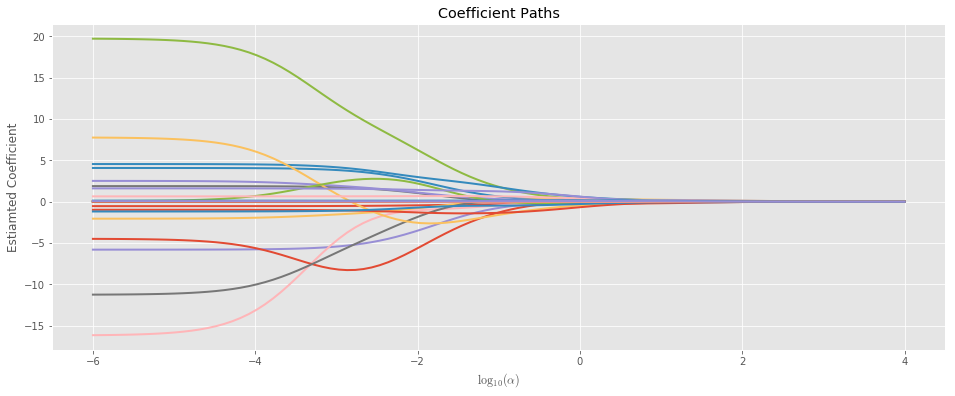

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, ridge_regressions)

Each curve here is the path of **one** estimated parameter in the model.

  - At the right hand side of the plot, $\alpha$ is very large.  As you can see, the estimated parameters in ridge regression all converge towards zero as the regularization strength goes to zero.
  - At the left hand side of the plot, $\alpha$ is very small.  The coefficient paths disperse in this direction, and settle into the linear regression parameter estimates.

In [15]:
lr = LinearRegression()
lr.fit(balance_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

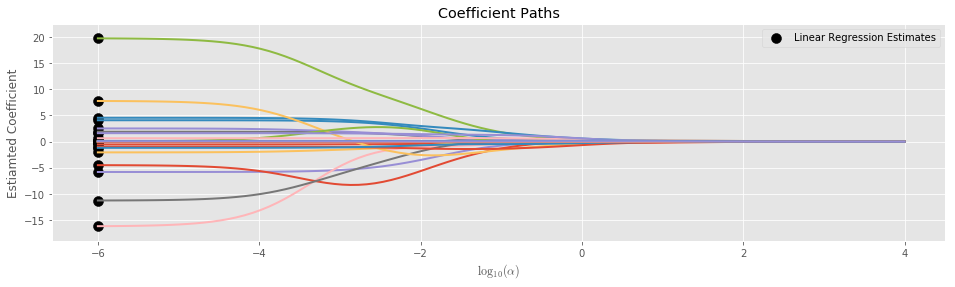

In [16]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_solution_paths(ax, ridge_regressions)
ax.scatter(np.repeat(-6, len(lr.coef_)), lr.coef_, color="black", s=100,
           label="Linear Regression Estimates")
ax.legend()

This gives us a good sense of what ridge regression is up to, but we would like to know which $\alpha$ is **best** for a given problem.  To do that, we evaluate the performance of each of our models using a test set.

In [17]:
def rss(model, X, y):
    preds = model.predict(X)
    n = X.shape[0]
    return np.sum((y - preds)**2) / n

def train_and_test_error(regressions, X_train, y_train, X_test, y_test):
    alphas = [ridge.alpha for ridge in regressions]
    train_scores = [rss(reg, X_train, y_train) for reg in regressions]
    test_scores = [rss(reg, X_test, y_test) for reg in regressions]
    return pd.DataFrame({
        'train_scores': train_scores,
        'test_scores': test_scores,
    }, index=alphas)

def get_optimal_alpha(train_and_test_errors):
    test_errors = train_and_test_errors["test_scores"]
    optimal_idx = np.argmin(test_errors.values)
    return train_and_test_errors.index[optimal_idx]

def plot_train_and_test_error(ax, train_and_test_errors, alpha=1.0, linewidth=2, legend=True):
    alphas = train_and_test_errors.index
    optimal_alpha = get_optimal_alpha(train_and_test_errors)
    ax.plot(np.log10(alphas), train_and_test_errors.train_scores, label="Train MSE",
            color="blue", linewidth=linewidth, alpha=alpha)
    ax.plot(np.log10(alphas), train_and_test_errors.test_scores, label="Test MSE",
            color="red", linewidth=linewidth, alpha=alpha)
    ax.axvline(x=np.log10(optimal_alpha), color="grey", alpha=alpha)
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("Mean Squared Error vs. Regularization Strength")
    if legend:
        ax.legend()

In [18]:
train_and_test_errors = train_and_test_error(
    ridge_regressions, balance_train, y_train, balance_test, y_test)

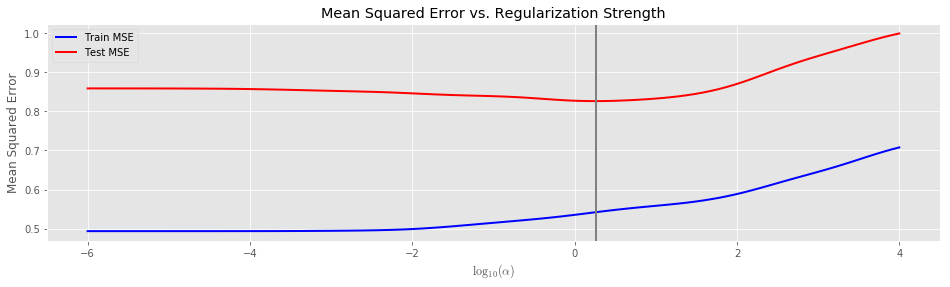

In [19]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_train_and_test_error(ax, train_and_test_errors)

This is a common, and expected picture.

The **training error** is monotonic with respect to the regularization parameter.  Linear regression gives the smallest training error, and increasing the regularization strength always increases the training error rate.

The **testing error** behaves differently.

  - Under regularizing results in an **overfit** model.  The model bias is at its lowest, but the model variance is high.
  - Over regularizing results in an **underfit** model.  The model bias is very high (we are essentially just predicting a constant), but the model variance is very low (that constant is relatively insensitive to the training data).
  
In the middle, we find a good compromise between bias and variance by finding the value of $\alpha$ that minimizes the test error.

In [20]:
ridge_optimal_alpha = get_optimal_alpha(train_and_test_errors)

### Fitting the Final Model

Once you have determined the best regularization parameter for your problem, it is best practice to then combine all your data and refit the model using this value of $\alpha$.

In [21]:
balance_pipeline.fit(balance)
final_train = balance_pipeline.transform(balance)
y_final = (balance["Balance"] - balance["Balance"].mean()) / balance["Balance"].std()

In [22]:
final_ridge_model = Ridge(alpha=ridge_optimal_alpha)
final_ridge_model.fit(final_train, y_final)

Ridge(alpha=1.830738280295366, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

We can now use this ridge regression to make predictions on our production data, comfortable that we have found a good balance between bias and variance.

## Lasso Regression

Ridge regression was the first regularization method discovered and studied.  Ridge is simple, and is often a very good tool for increasing the predictive power of linear models.

None the less, there are situations that ridge regression does not address.  In some situations we suspect that but a very few predictors of many may be driving a phenomena.  For example, in detecting which genes drive a disease or syndrome, we do not suspect that "all genes contribute a little bit", but that "most contribute nothing, a few contribute a lot".

Since ridge regression leaves **all** predictors in the model, only shrinking their parameter estimates, it is inappropriate for these situations.

**[Lasso Regression](https://en.wikipedia.org/wiki/Lasso_(statistics)** was introduced by Robert Tibshirani in 1996 to address this situation, it is much like ridge, but instead of shrinking estimates asymptotically to zero, it shrinks estimates exactly **to zero**, removing them from contributing to the model.

### The Optimization Problem

Lasso makes a simple change to the ridge loss function, but one that drastically changes its behaviour.

$$ \hat \beta_{lasso} = argimin_{\beta} \frac{1}{n} \sum_i (y_i - \hat y_i)^2 + \alpha \sum_{j \geq 1} \| \beta_j \| $$

The regularization term now penalizes the absolute value of the coefficients, not their square.  This has a drastic effect on the solution path for the parameter estimates.

In [23]:
from sklearn.linear_model import Lasso

In [24]:
lasso_regularization_strengths = np.logspace(np.log10(0.00001), np.log10(10), num=100)

lasso_regressions = []
for alpha in lasso_regularization_strengths:
    lasso = Lasso(alpha=alpha)
    lasso.fit(balance_train, y_train)
    lasso_regressions.append(lasso)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


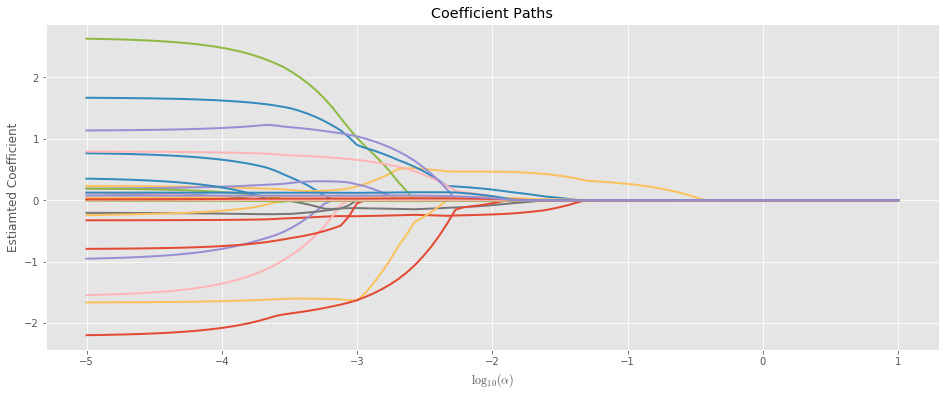

In [25]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, lasso_regressions)

Notice now that coefficients are set **exactly to zero**, instead of gradually shrinking towards zero but never getting there.  This means that lasso models tend to have a small number of non-zero parameters, while ridge models have many non-zero parameters.

Evaluating a lasso regression is accomplished in the same way as with ridge regression.

In [26]:
train_and_test_errors = train_and_test_error(
    lasso_regressions, balance_train, y_train, balance_test, y_test)

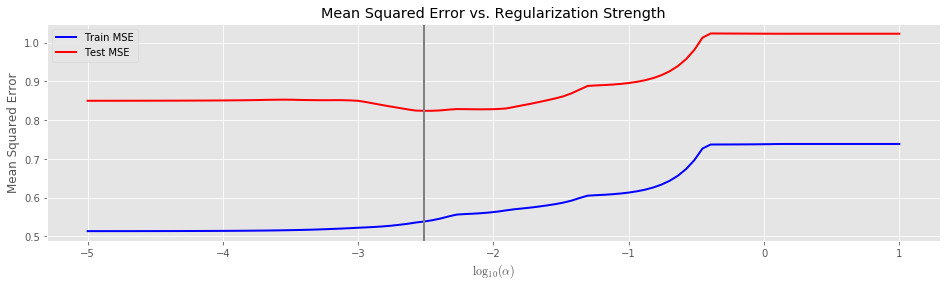

In [27]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_train_and_test_error(ax, train_and_test_errors)

## Using Ridge and Lasso with Cross Validation

It is not often a good idea to use a single training and testing set when evaluating the performance of regularized regressions, too much risk is bundled up in the splitting of your data.

As is usual, much better is to use cross validation.

In [28]:
from sklearn.model_selection import KFold

In [29]:
n_folds=10

cv_models = []
errors = []
splitter = KFold(n_splits=n_folds)
for train_idxs, test_idxs in splitter.split(balance):
    # Split the raw data into train and test
    train_raw, test_raw = balance.iloc[train_idxs], balance.iloc[test_idxs]
    
    # Fit and transform the raw data.
    # All training of the transformers must only touch tfhe training data!
    balance_pipeline.fit(train_raw)
    balance_train_cv = balance_pipeline.transform(train_raw)
    balance_test_cv = balance_pipeline.transform(test_raw)
    y_train_cv, y_test_cv = standardize_y(train_raw["Balance"], test_raw["Balance"])
    
    # Fit all the models at different regularization strengths
    ridge_regressions = []
    for alpha in ridge_regularization_strengths:
        ridge = Ridge(alpha=alpha)
        ridge.fit(balance_train_cv, y_train_cv)
        ridge_regressions.append(ridge)
    cv_models.append(ridge_regressions)
    
    # Calculate the error curves for each CV fold, for each regularization strength
    train_and_test_errors = train_and_test_error(
        ridge_regressions, balance_train_cv, y_train_cv, balance_test_cv, y_test_cv)
    errors.append(train_and_test_errors)
    
    # Calculate the mean errors across all CV folds, for each regularization strength
    train_errors = np.empty(shape=(n_folds, len(ridge_regularization_strengths)))
    for idx, tte in enumerate(errors):
        te = tte['train_scores']
        train_errors[idx, :] = te
    mean_train_errors = np.mean(train_errors, axis=0)
    
    test_errors = np.empty(shape=(n_folds, len(ridge_regularization_strengths)))
    for idx, tte in enumerate(errors):
        te = tte['test_scores']
        test_errors[idx, :] = te
    mean_test_errors = np.mean(test_errors, axis=0)
    
    mean_errors = pd.DataFrame({
        'train_scores': mean_train_errors,
        'test_scores': mean_test_errors,
    }, index=ridge_regularization_strengths)

To illustrate the variance that different splits into training and testing sets can have, here are the coefficient paths for all of the 10 models fit through cross validation.

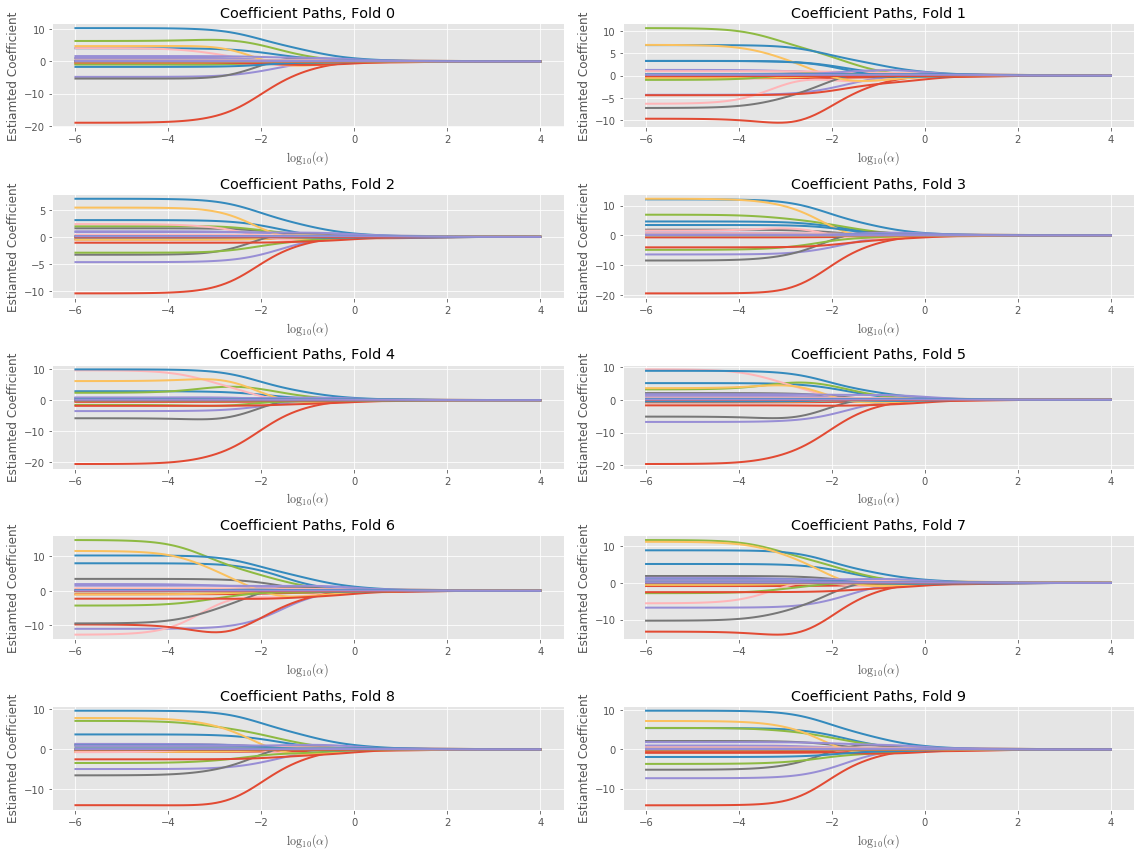

In [30]:
fig, axs = plt.subplots(5, 2, figsize=(16, 12))

for idx, ax in enumerate(axs.flatten()):
    plot_solution_paths(ax, cv_models[idx])
    ax.set_title("Coefficient Paths, Fold {}".format(idx))
fig.tight_layout()

And here are the various training and testing error curves.

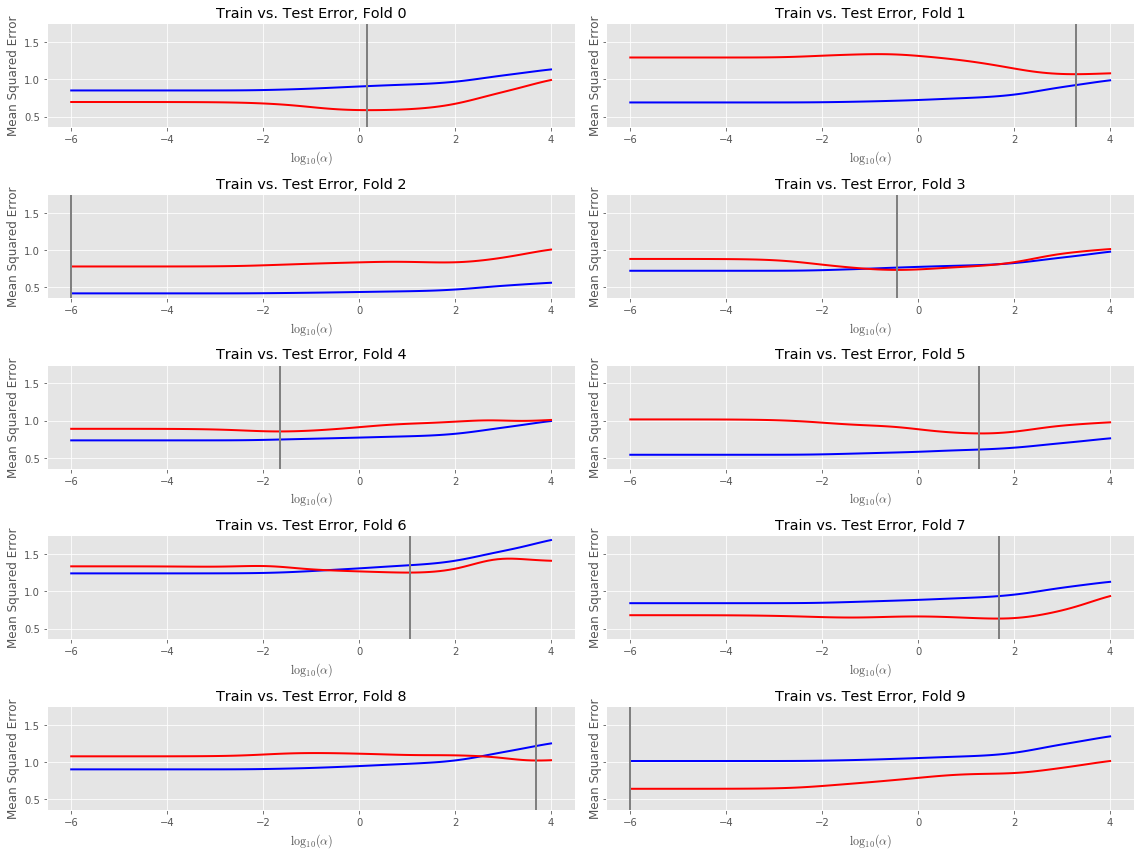

In [31]:
fig, axs = plt.subplots(5, 2, figsize=(16, 12), sharey=True)

for idx, (ax, ttes) in enumerate(zip(axs.flatten(), errors)):
    plot_train_and_test_error(ax, ttes, legend=False)
    ax.set_title("Train vs. Test Error, Fold {}".format(idx))
fig.tight_layout()

You can clearly see here that some folds result in "easy" testing sets, and some folds result in "hard" test sets.

To get a final value of $\alpha$ to use, we average these training and testing error curves, and then take the minimum average testing error.  This leads to a more stable estimate of $\alpha$, and is a best practice.

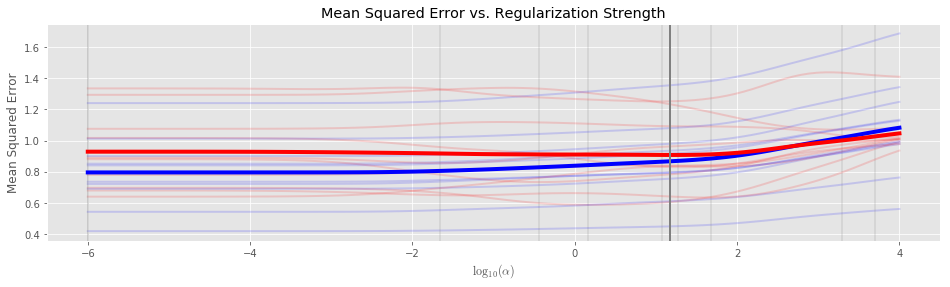

In [32]:
fig, ax = plt.subplots(figsize=(16, 4))

for ttes in errors:
    plot_train_and_test_error(ax, ttes, alpha=0.15, legend=False)
plot_train_and_test_error(ax, mean_errors, linewidth=4, legend=False)